In [1]:
import pandas as pd
import numpy as np
from plotly import express as px

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

ModuleNotFoundError: No module named 'plotly'

In [2]:
import os
from os import listdir
from os.path import isfile, join

mypath = "../../NBA_kaggle/"
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
files

['../../NBA_kaggle/teams.csv',
 '../../NBA_kaggle/players.csv',
 '../../NBA_kaggle/games.csv',
 '../../NBA_kaggle/ranking.csv',
 '../../NBA_kaggle/games_details.csv']

In [4]:
dfs = {}
for file_path in files:
    dfs[file_path.split(".")[-2].split("/")[-1]] = pd.read_csv(file_path)

/var/folders/1p/dx2hbmg90j579twjxstztgvh0000gn/T/ipykernel_12659/51685974.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[file_path.split(".")[-2].split("/")[-1]] = pd.read_csv(file_path)


In [5]:
dfs.keys()

dict_keys(['teams', 'players', 'games', 'ranking', 'games_details'])

In [80]:
# the features we use for our prediction
PRED_COLS = ['AST', 'BLK', 'DREB', 'FG3A', 'FG3M', 'FGA', 'FGM', 'FTA', 'FTM', 'OREB', 'PF', 'STL', 'TO']

REGULAR_SEASON_DURATION = {
    2021: ('2021-10-19', '2022-04-10'),
    2020: ('2020-12-22', '2021-05-16'),
    2018: ('2018-10-16', '2019-04-10'),
    2017: ('2017-10-17', '2018-04-11'),
}

DATA_ROOT = os.path.join('..', 'backend-project', 'data')

# EDA

In [25]:
import dtale

# open dtale for EDA
dtale.show(dfs['games_details'])

/Users/dustinbrunner/mambaforge/envs/iml_project/lib/python3.10/site-packages/dtale/views.py:755: FutureWarning:

['NICKNAME', 'START_POSITION', 'COMMENT', 'MIN'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



In [26]:
dfs['games'].describe()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
count,2.665100e+04,2.665100e+04,2.665100e+04,26651.000000,2.665100e+04,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,2.665100e+04,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,26552.000000,26651.000000
mean,2.175487e+07,1.610613e+09,1.610613e+09,2012.113879,1.610613e+09,103.455898,0.460735,0.760377,0.356023,22.823441,43.374284,1.610613e+09,100.639876,0.449732,0.758816,0.349489,21.496271,42.113249,0.587032
std,5.570189e+06,8.638670e+00,8.659299e+00,5.587031,8.638670e+00,13.283370,0.056676,0.100677,0.111164,5.193308,6.625769,8.659299e+00,13.435868,0.055551,0.103429,0.109441,5.160596,6.533039,0.492376
min,1.030000e+07,1.610613e+09,1.610613e+09,2003.000000,1.610613e+09,36.000000,0.250000,0.143000,0.000000,6.000000,15.000000,1.610613e+09,33.000000,0.244000,0.143000,0.000000,4.000000,19.000000,0.000000
25%,2.070001e+07,1.610613e+09,1.610613e+09,2007.000000,1.610613e+09,94.000000,0.422000,0.697000,0.286000,19.000000,39.000000,1.610613e+09,91.000000,0.412000,0.692000,0.278000,18.000000,38.000000,0.000000
50%,2.120076e+07,1.610613e+09,1.610613e+09,2012.000000,1.610613e+09,103.000000,0.460000,0.765000,0.357000,23.000000,43.000000,1.610613e+09,100.000000,0.449000,0.765000,0.350000,21.000000,42.000000,1.000000
75%,2.180005e+07,1.610613e+09,1.610613e+09,2017.000000,1.610613e+09,112.000000,0.500000,0.833000,0.429000,26.000000,48.000000,1.610613e+09,110.000000,0.487000,0.833000,0.419000,25.000000,46.000000,1.000000
max,5.210021e+07,1.610613e+09,1.610613e+09,2022.000000,1.610613e+09,168.000000,0.684000,1.000000,1.000000,50.000000,72.000000,1.610613e+09,168.000000,0.687000,1.000000,1.000000,46.000000,81.000000,1.000000


In [28]:
team_id = 1610612738

# load data
data = dfs['games']

# only use season 2021
data = data[data['SEASON']==2021]

# select team data for home and away games
team_data = []
for s in ['home', 'away']:
    df = data[data[f'TEAM_ID_{s}']==team_id]
    df = df[[col for col in df.columns if col.endswith(f'_{s}')]]
    df.columns = df.columns.str.rstrip(f'_{s}')
    team_data.append(df)

# combine data
team_data = pd.concat(team_data)
# aggregate data by calculating mean
team_data_agg = team_data.mean().to_frame().T
team_data_agg.to_dict("records")


[{'TEAM_ID': 1610612738.0,
  'PTS': 110.0909090909091,
  'FG_PCT': 0.4616181818181818,
  'FT_PCT': 0.8137727272727272,
  'FG3_PCT': 0.3564181818181818,
  'AST': 24.681818181818183,
  'REB': 45.35454545454545}]

In [29]:
dfs['games'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   HOME_TEAM_ID      26651 non-null  int64  
 4   VISITOR_TEAM_ID   26651 non-null  int64  
 5   SEASON            26651 non-null  int64  
 6   TEAM_ID_home      26651 non-null  int64  
 7   PTS_home          26552 non-null  float64
 8   FG_PCT_home       26552 non-null  float64
 9   FT_PCT_home       26552 non-null  float64
 10  FG3_PCT_home      26552 non-null  float64
 11  AST_home          26552 non-null  float64
 12  REB_home          26552 non-null  float64
 13  TEAM_ID_away      26651 non-null  int64  
 14  PTS_away          26552 non-null  float64
 15  FG_PCT_away       26552 non-null  float64
 16  FT_PCT_away       26552 non-null  float6

In [30]:
from flask import jsonify

In [31]:
print(df_season['HOME_TEAM_ID'].unique().tolist(), end='')

NameError: name 'df_season' is not defined

In [32]:
team_id = 1610612744
for team_id in df_season['HOME_TEAM_ID'].unique():
    print(len(df_season[(df_season['HOME_TEAM_ID']==team_id) | (df_season['VISITOR_TEAM_ID']==team_id)]))

NameError: name 'df_season' is not defined

In [33]:
team_id = 1610612744
df_team_home = df_season[df_season['TEAM_ID_home']==team_id]
df_team_away = df_season[df_season['TEAM_ID_away']==team_id]

NameError: name 'df_season' is not defined

In [34]:
df_home = df_team_home[[col for col in df_team_home.columns if col.endswith('_home')]]
df_home.columns = df_home.columns.str.rstrip('_home')
df_home

NameError: name 'df_team_home' is not defined

In [35]:
df_away = df_team_away[[col for col in df_team_home.columns if col.endswith('_away')]]
df_away.columns = df_away.columns.str.rstrip('_away')
df_away

NameError: name 'df_team_away' is not defined

In [36]:
df_team_merged = pd.concat([df_home, df_away])
df_team_merged.mean().to_dict()

NameError: name 'df_home' is not defined

In [37]:
home_team_id = 1610612738
visitor_team_id = 1610612744

In [38]:
home_data = data[data["HOME_TEAM_ID"] == int(home_team_id)]
match_up_data = home_data[home_data["VISITOR_TEAM_ID"] == int(visitor_team_id)]

In [39]:
match_up_data

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
542,2022-06-16,42100406,Final,1610612738,1610612744,2021,1610612738,90.0,0.425,0.917,0.393,27.0,41.0,1610612744,103.0,0.413,1.000,0.413,27.0,44.0,0
544,2022-06-10,42100404,Final,1610612738,1610612744,2021,1610612738,97.0,0.400,0.737,0.395,22.0,42.0,1610612744,107.0,0.440,0.800,0.349,20.0,55.0,0
545,2022-06-08,42100403,Final,1610612738,1610612744,2021,1610612738,116.0,0.483,0.708,0.371,28.0,47.0,1610612744,100.0,0.462,0.867,0.375,22.0,31.0,1
1429,2021-12-17,22100435,Final,1610612738,1610612744,2021,1610612738,107.0,0.439,0.690,0.366,20.0,45.0,1610612744,111.0,0.433,0.810,0.348,27.0,45.0,0


In [40]:
data = dfs['games']
season = 2021
data_season = data[data['SEASON']==season]

# calculate for every team their average statistics
data_teams = []
for team_id in data_season['TEAM_ID_home'].unique():
    curr_team_data = []
    # do same selection for both home & away games
    for s in ['home', 'away']:
        df = data_season[data_season[f'TEAM_ID_{s}']==team_id]
        df = df[[col for col in df.columns if col.endswith(f'_{s}')]]
        df.columns = df.columns.str.rstrip(f'_{s}')
        curr_team_data.append(df)

    curr_team_data = pd.concat(curr_team_data)
    # aggregate data using mean()
    curr_team_data_agg = curr_team_data.mean()
    curr_team_data_agg['TEAM_ID'] = curr_team_data_agg['TEAM_ID'].astype(int)
    data_teams.append(curr_team_data_agg.to_frame().T)

# combine aggregate stats of all teams
data_teams = pd.concat(data_teams)
data_teams.to_dict("records")

[{'TEAM_ID': 1610612738.0,
  'PTS': 110.0909090909091,
  'FG_PCT': 0.4616181818181818,
  'FT_PCT': 0.8137727272727272,
  'FG3_PCT': 0.3564181818181818,
  'AST': 24.681818181818183,
  'REB': 45.35454545454545},
 {'TEAM_ID': 1610612744.0,
  'PTS': 111.4954128440367,
  'FG_PCT': 0.47073394495412846,
  'FT_PCT': 0.7715871559633029,
  'FG3_PCT': 0.3661926605504587,
  'AST': 27.211009174311926,
  'REB': 45.27522935779817},
 {'TEAM_ID': 1610612748.0,
  'PTS': 109.0754716981132,
  'FG_PCT': 0.4636981132075471,
  'FT_PCT': 0.8063679245283019,
  'FG3_PCT': 0.36713207547169807,
  'AST': 24.764150943396228,
  'REB': 43.509433962264154},
 {'TEAM_ID': 1610612742.0,
  'PTS': 108.13461538461539,
  'FG_PCT': 0.4603076923076923,
  'FT_PCT': 0.7748173076923076,
  'FG3_PCT': 0.35500961538461545,
  'AST': 22.903846153846153,
  'REB': 42.44230769230769},
 {'TEAM_ID': 1610612756.0,
  'PTS': 113.93939393939394,
  'FG_PCT': 0.4872424242424242,
  'FT_PCT': 0.801828282828283,
  'FG3_PCT': 0.36358585858585857,
  

In [41]:
home_teams = dfs['games']['TEAM_ID_home'].unique().tolist()

In [42]:
away_teams = dfs['games']['TEAM_ID_away'].unique().tolist()

In [43]:
home_counts = dict(dfs['games']['TEAM_ID_home'].value_counts())
away_counts = dict(dfs['games']['TEAM_ID_away'].value_counts())
total_counts = {}
for team_id in home_counts:
    total_counts[team_id] = home_counts[team_id] + away_counts[team_id]

In [44]:
home_win_counts = dfs['games'][["TEAM_ID_home", "HOME_TEAM_WINS"]].groupby("TEAM_ID_home").sum().to_dict()['HOME_TEAM_WINS']
dfs['games']['AWAY_TEAM_WINS'] = 
away_win_counts = dfs['games'][["TEAM_ID_home", "HOME_TEAM_WINS"]].groupby("TEAM_ID_home").sum().to_dict()['HOME_TEAM_WINS']

SyntaxError: invalid syntax (2900065925.py, line 2)

In [45]:
win_ratio = {}
for team_id, game_count in total_counts.items():
    win_ratio[team_id] = win_counts[team_id]/game_count

NameError: name 'win_counts' is not defined

In [46]:
win_ratio

{}

In [47]:
import random
import string

char_set = string.ascii_lowercase + string.digits

# Generate the random string
rand_string = ''.join(random.choices(char_set, k=3))

print([''.join(random.choices(char_set, k=3)) for i in range(28)], end='')

['07t', 'wn4', 'xyq', 'hyi', '7n6', '265', 'p24', 'e1l', 'w9w', 'n7a', 'b94', 'hiy', 'fo7', '8y2', 'rgn', '4hq', '7ug', 'b4p', 'j83', 'g4o', 'm3t', 'rjy', 'vkg', 'jmz', 'gph', 'xvk', 'v5o', 'hdl']

In [48]:
['b21','vff','y4p','osz','qe3','xpo','fck','pzj','opq','sd8','ykz','tmi','dve','n0l','dnc','uoe','21j','vvt','9gv','yp0','c6j','h18','1jm','e6s','vxv','id0','sgn','5fs']

['b21',
 'vff',
 'y4p',
 'osz',
 'qe3',
 'xpo',
 'fck',
 'pzj',
 'opq',
 'sd8',
 'ykz',
 'tmi',
 'dve',
 'n0l',
 'dnc',
 'uoe',
 '21j',
 'vvt',
 '9gv',
 'yp0',
 'c6j',
 'h18',
 '1jm',
 'e6s',
 'vxv',
 'id0',
 'sgn',
 '5fs']

In [49]:
[2,1,1,2,1,0,2,0,1,2,1,1,1,0,2,2,1,2,0,1,2,2,0,0,0,2,2,1]

[2,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 1]

In [50]:
[0.8275131283799484,0.09487005827496886,0.31041982209241914,0.3674962874638086,0.9894704688397509,0.6976517583253099,0.2510739347176133,0.7038244000379689,0.281104627126173,0.24453436720481747,0.21572455280679714,0.9450996102974045,0.06269897793000201,0.927445707491646,0.8770351565451876,0.37410866615621996,0.06852823003976771,0.9542841047005347,0.3554845475418352,0.8933954793147186,0.8989566358061083,0.9274175518167309,0.25198713794531924,0.6835699504868009,0.5568529822794931,0.3023572836984173,0.690922175667046,0.13804199601898415]

[0.8275131283799484,
 0.09487005827496886,
 0.31041982209241914,
 0.3674962874638086,
 0.9894704688397509,
 0.6976517583253099,
 0.2510739347176133,
 0.7038244000379689,
 0.281104627126173,
 0.24453436720481747,
 0.21572455280679714,
 0.9450996102974045,
 0.06269897793000201,
 0.927445707491646,
 0.8770351565451876,
 0.37410866615621996,
 0.06852823003976771,
 0.9542841047005347,
 0.3554845475418352,
 0.8933954793147186,
 0.8989566358061083,
 0.9274175518167309,
 0.25198713794531924,
 0.6835699504868009,
 0.5568529822794931,
 0.3023572836984173,
 0.690922175667046,
 0.13804199601898415]

# Detailed Boxscore

**Remember cutting out the playoffs!**

Regular season began October 19, 2021, and ended on April 10, 2022

In [7]:
def get_season_games(season=2021):
    games = dfs['games'].copy()
    games = games[['TEAM_ID_home', 'TEAM_ID_away', 'HOME_TEAM_WINS', 'GAME_ID', 'GAME_DATE_EST']]
    
    regular_games = games[(REGULAR_SEASON_DURATION[season][0] <= pd.to_datetime(games['GAME_DATE_EST'])) & (pd.to_datetime(games['GAME_DATE_EST']) <= REGULAR_SEASON_DURATION[season][1])]
    
    return regular_games

def get_team_boxscore(team_id=1610612738, is_home=True):
    games = get_season_games(2021)
    games_details = dfs['games_details'].copy()
    # join games to games_details for date information
    games_details = games_details.merge(games, on='GAME_ID')

    # add additional column indicating whether team is home or not
    games_details['is_home'] = games_details['TEAM_ID'] == games_details['TEAM_ID_home']

    # select data from team at home or away
    games_details = games_details[(games_details['TEAM_ID']==team_id) & (games_details['is_home']==is_home)][PRED_COLS+['GAME_ID']]

    # sum over all players for each game and then average over all games
    boxscore = games_details.groupby(['GAME_ID']).sum().mean().to_frame().T
    
    return boxscore


def get_season_boxscore(season=2021):
    games = get_season_games(season)
    games_details = dfs['games_details'].copy()
    
    # add games details to regular season games
    games_details = games_details.merge(games, on='GAME_ID')

    # add additional column indicating whether team is home or not
    games_details['is_home'] = games_details['TEAM_ID'] == games_details['TEAM_ID_home']
    
    games_details = games_details[PRED_COLS + ['GAME_ID', 'TEAM_ID', 'is_home']]
    # group by game and team and sum stats
    games_details_agg = games_details.groupby(['GAME_ID', 'TEAM_ID']).sum()
    # reset is_home col to boolean value
    games_details_agg['is_home'] = games_details_agg['is_home'] > 0
    # group by team and is_home
    games_details_agg = games_details_agg.groupby(['TEAM_ID', 'is_home']).mean()
    # only keep prediction columns
    games_details_agg = games_details_agg[PRED_COLS]
    games_details_agg = games_details_agg.reset_index()
    return games_details_agg


def get_train_data(season=2021):
    season_games = get_season_games(season)
    games_details = get_season_boxscore(season)
    
    # add stats of home teams
    train_data = season_games.merge(games_details[games_details['is_home']].drop(columns='is_home'), left_on='TEAM_ID_home', right_on='TEAM_ID')
    # rename stats cols
    train_data = train_data.rename(columns={col: f"{col}_home" for col in PRED_COLS})
    # add stats of away teams
    train_data = train_data.merge(games_details[~games_details['is_home']].drop(columns='is_home'), left_on='TEAM_ID_away', right_on='TEAM_ID')
    # rename stats cols
    train_data = train_data.rename(columns={col: f"{col}_away" for col in PRED_COLS})
    
    # only return feature and target columns
    return train_data[[f"{col}_home" for col in PRED_COLS]+[f"{col}_away" for col in PRED_COLS]+['HOME_TEAM_WINS']]
    

In [19]:
get_season_games()

,TEAM_ID_home,TEAM_ID_away,HOME_TEAM_WINS,GAME_ID,GAME_DATE_EST
635,1610612751,1610612754,1,22101216,2022-04-10
636,1610612766,1610612764,1,22101217,2022-04-10
637,1610612739,1610612749,1,22101218,2022-04-10
638,1610612745,1610612737,0,22101221,2022-04-10
639,1610612763,1610612738,0,22101223,2022-04-10
...,...,...,...,...,...
1860,1610612762,1610612760,1,22100011,2021-10-20
1861,1610612756,1610612743,0,22100012,2021-10-20
1862,1610612757,1610612758,0,22100013,2021-10-20
1863,1610612749,1610612751,1,22100001,2021-10-19


In [20]:
get_team_boxscore(is_home=True)

,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO
0,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.0,7.463415,13.097561


In [21]:
get_season_boxscore()

,TEAM_ID,is_home,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO
0,1610612737,False,24.000000,3.878049,33.609756,33.634146,12.414634,89.585366,41.048780,20.829268,16.707317,10.731707,18.487805,6.512195,11.439024
1,1610612737,True,25.195122,4.609756,34.268293,35.170732,13.341463,87.024390,41.902439,23.780488,19.512195,9.341463,18.926829,7.804878,11.097561
2,1610612738,False,25.146341,5.975610,36.390244,38.560976,13.902439,87.536585,40.780488,21.268293,17.292683,10.146341,19.097561,6.951220,13.000000
3,1610612738,True,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.000000,7.463415,13.097561
4,1610612739,False,24.926829,4.121951,33.390244,31.658537,11.048780,84.560976,39.756098,21.902439,16.951220,10.195122,17.439024,6.853659,13.341463
5,1610612739,True,25.414634,4.243902,34.560976,33.853659,12.195122,84.707317,39.634146,22.243902,16.609756,10.219512,17.512195,7.292683,13.195122
6,1610612740,False,24.073171,4.000000,33.292683,30.682927,10.219512,87.024390,38.975610,24.414634,19.048780,11.780488,19.536585,8.512195,13.365854
7,1610612740,True,25.853659,4.000000,33.195122,33.439024,11.073171,88.878049,41.365854,22.000000,17.560976,12.146341,19.780488,8.073171,13.195122
8,1610612741,False,23.463415,4.121951,32.975610,29.097561,10.658537,85.658537,40.682927,20.829268,17.000000,8.024390,19.219512,7.317073,12.951220
9,1610612741,True,24.292683,4.073171,34.341463,28.560976,10.609756,88.170732,42.780488,22.243902,18.024390,9.317073,18.341463,6.951220,11.292683


In [22]:
get_train_data()

,AST_home,BLK_home,DREB_home,FG3A_home,FG3M_home,FGA_home,FGM_home,FTA_home,FTM_home,OREB_home,...,FG3M_away,FGA_away,FGM_away,FTA_away,FTM_away,OREB_away,PF_away,STL_away,TO_away,HOME_TEAM_WINS
0,25.073171,5.707317,34.536585,31.121951,10.317073,88.439024,41.195122,21.926829,17.731707,10.975610,...,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
1,25.073171,5.707317,34.536585,31.121951,10.317073,88.439024,41.195122,21.926829,17.731707,10.975610,...,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
2,28.268293,5.560976,34.951220,38.707317,13.560976,91.317073,42.390244,20.926829,15.121951,11.390244,...,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
3,28.268293,5.560976,34.951220,38.707317,13.560976,91.317073,42.390244,20.926829,15.121951,11.390244,...,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
4,25.414634,4.243902,34.560976,33.853659,12.195122,84.707317,39.634146,22.243902,16.609756,10.219512,...,12.000000,88.682927,39.878049,22.292683,16.951220,11.000000,20.731707,6.804878,13.731707,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,27.219512,5.536585,32.219512,35.439024,12.317073,90.292683,43.000000,20.487805,15.902439,11.560976,...,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,0
1226,22.634146,5.000000,35.170732,37.341463,12.341463,88.829268,38.926829,18.975610,14.463415,10.609756,...,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,0
1227,23.756098,4.658537,33.195122,32.634146,11.658537,86.195122,40.048780,23.780488,18.560976,8.975610,...,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,1
1228,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,...,12.609756,88.414634,42.756098,21.512195,17.243902,9.609756,21.048780,7.243902,12.121951,1


In [23]:
def get_team_games(games: pd.DataFrame, team_id: int):
    cols_to_keep = ['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS']
    team_games = []
    for s in ['home', 'away']:
        # filter games of this team
        games_loc = games[games[f'TEAM_ID_{s}']==team_id]
        # select columns to keep
        games_loc = games_loc[cols_to_keep + [col for col in games_loc if col.endswith(f'_{s}')]]
        games_loc.columns = games_loc.columns.str.rstrip(f'_{s}')
        games_loc['won'] = games_loc['HOME_TEAM_WINS'].apply(lambda w: w if s=='home' else 1-w)
        games_loc['at_home'] = games_loc['HOME_TEAM_ID'] == team_id
        games_loc = games_loc.drop(columns='HOME_TEAM_WINS')
        team_games.append(games_loc)
        
    team_games = pd.concat(team_games, axis=0)
    return team_games

team_games = get_team_games(dfs['games'], 1610612737)
team_games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID,PTS,FG_PCT,FT_PCT,FG3_PCT,AST,REB,won,at_home
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,0.378,22.0,47.0,0,True
20,2022-12-19,22200454,Final,1610612737,1610612753,2022,1610612737,126.0,0.511,0.900,0.375,29.0,41.0,1,True
82,2022-12-11,22200400,Final,1610612737,1610612741,2022,1610612737,123.0,0.480,0.762,0.333,28.0,45.0,1,True
121,2022-12-05,22200354,Final,1610612737,1610612760,2022,1610612737,114.0,0.431,0.765,0.342,24.0,54.0,0,True
143,2022-12-02,22200327,Final,1610612737,1610612743,2022,1610612737,117.0,0.557,0.643,0.357,24.0,43.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26533,2014-10-29,21400008,Final,1610612761,1610612737,2014,1610612737,102.0,0.500,0.529,0.591,26.0,42.0,0,False
26561,2014-10-22,11400105,Final,1610612759,1610612737,2014,1610612737,117.0,0.519,0.735,0.480,29.0,34.0,1,False
26595,2014-10-16,11400060,Final,1610612741,1610612737,2014,1610612737,84.0,0.388,0.833,0.259,21.0,46.0,0,False
26606,2014-10-14,11400052,Final,1610612748,1610612737,2014,1610612737,109.0,0.488,0.750,0.382,27.0,45.0,1,False


In [24]:
# number of games on each day
px.bar(get_season_games().groupby('GAME_DATE_EST').count()['TEAM_ID_home'], height=800)

NameError: name 'px' is not defined

# Clustering

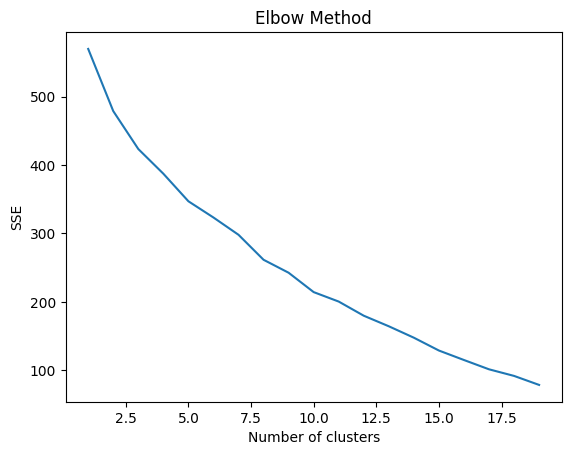

In [64]:
# import necessary packages
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# load dataset
df = detailed_boxscore

# remove non-numeric columns
df = df.select_dtypes(include=['float64', 'int64'])

# normalize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# elbow method to determine optimal number of clusters
sse = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 20), sse)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# fit k-means algorithm to data
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(df_scaled)

# add cluster labels to original dataset
df['Cluster'] = kmeans.labels_


In [65]:
df = detailed_boxscore
df = df[[col for col in df.columns if col != 'at_home' and not col.endswith('_PCT') and col.lower() != 'cluster']].copy()

In [66]:
df

,TEAM_ID,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
0,1610612737,41.475610,88.304878,12.878049,34.402439,18.109756,22.304878,10.036585,33.939024,43.975610,24.597561,7.158537,4.243902,11.268293,18.707317,113.939024
1,1610612738,40.743902,87.402439,13.231707,37.121951,17.036585,20.890244,10.524390,35.548780,46.073171,24.829268,7.207317,5.829268,13.048780,18.548780,111.756098
2,1610612739,39.695122,84.634146,11.621951,32.756098,16.780488,22.073171,10.207317,33.975610,44.182927,25.170732,7.073171,4.182927,13.268293,17.475610,107.792683
3,1610612740,40.170732,87.951220,10.646341,32.060976,18.304878,23.207317,11.963415,33.243902,45.207317,24.963415,8.292683,4.000000,13.280488,19.658537,109.292683
4,1610612741,41.731707,86.914634,10.634146,28.829268,17.512195,21.536585,8.670732,33.658537,42.329268,23.878049,7.134146,4.097561,12.121951,18.780488,111.609756
5,1610612742,39.292683,85.158537,13.085366,37.353659,16.353659,21.207317,9.268293,33.768293,43.036585,23.390244,6.731707,3.963415,11.707317,19.658537,108.024390
6,1610612743,41.658537,86.329268,12.670732,35.902439,16.731707,21.036585,9.170732,34.939024,44.109756,27.792683,7.219512,3.719512,13.841463,19.987805,112.719512
7,1610612744,40.524390,86.426829,14.341463,39.402439,15.609756,20.304878,9.756098,35.731707,45.487805,27.109756,8.768293,4.536585,14.317073,21.012195,111.000000
8,1610612745,39.378049,86.378049,13.475610,38.658537,17.487805,24.512195,9.585366,32.439024,42.024390,23.560976,7.317073,4.658537,15.658537,20.634146,109.719512
9,1610612746,40.060976,87.439024,12.768293,34.170732,15.524390,19.585366,9.109756,34.878049,43.987805,24.012195,7.414634,4.951220,13.024390,18.634146,108.414634


In [243]:
all_bs

,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO,is_home,TEAM_ID
0,25.146341,5.975610,36.390244,38.560976,13.902439,87.536585,40.780488,21.268293,17.292683,10.146341,19.097561,6.951220,13.000000,False,1610612738
1,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.000000,7.463415,13.097561,True,1610612738
2,26.048780,4.268293,34.829268,38.073171,13.658537,85.268293,39.536585,21.097561,16.268293,9.365854,21.268293,8.390244,14.268293,False,1610612744
3,28.170732,4.804878,36.634146,40.731707,15.024390,87.585366,41.512195,19.512195,14.951220,10.146341,20.756098,9.146341,14.365854,True,1610612744
4,25.243902,3.390244,34.268293,36.804878,14.048780,85.170732,39.121951,21.219512,17.000000,9.804878,20.536585,7.487805,14.024390,False,1610612748
5,25.731707,3.073171,33.487805,34.804878,13.121951,84.439024,40.048780,21.536585,17.536585,9.878049,20.414634,7.292683,13.512195,True,1610612748
6,23.609756,4.097561,33.975610,35.951220,12.487805,84.853659,39.292683,21.195122,16.609756,8.853659,19.926829,6.804878,12.268293,False,1610612742
7,23.170732,3.829268,33.560976,38.756098,13.682927,85.463415,39.292683,21.219512,16.097561,9.682927,19.390244,6.658537,11.146341,True,1610612742
8,26.756098,3.853659,34.975610,31.487805,11.146341,90.487805,43.365854,20.195122,16.317073,9.365854,20.585366,9.073171,12.121951,False,1610612756
9,27.975610,4.902439,36.073171,32.317073,12.048780,89.731707,43.975610,19.682927,15.463415,10.170732,19.243902,8.048780,12.560976,True,1610612756


In [242]:
bs = all_bs

In [260]:
def get_clustering(df_boxscores: pd.DataFrame, n_components: int = 10, n_clusters: int = 3):
    
    df_cluster = df_boxscores.copy()
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_cluster[PRED_COLS])
    
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(df_scaled)
    
    kmeans = KMeans(n_clusters=3)
    kmeans.fit(pca_data)
    
    # add clustering columns
    df_cluster['x_coord'] = [coord[0] for coord in df_pca]
    df_cluster['y_coord'] = [coord[1] for coord in df_pca]
    df_cluster['cluster'] = kmeans.labels_
    
    return df_cluster

In [261]:
px.get_clustering(all_bs)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO,is_home,TEAM_ID,x_coord,y_coord,cluster
0,25.146341,5.975610,36.390244,38.560976,13.902439,87.536585,40.780488,21.268293,17.292683,10.146341,19.097561,6.951220,13.000000,False,1610612738,0.219580,0.516797,1
1,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.000000,7.463415,13.097561,True,1610612738,0.442948,-0.618259,1
2,26.048780,4.268293,34.829268,38.073171,13.658537,85.268293,39.536585,21.097561,16.268293,9.365854,21.268293,8.390244,14.268293,False,1610612744,-0.562291,1.345807,1
3,28.170732,4.804878,36.634146,40.731707,15.024390,87.585366,41.512195,19.512195,14.951220,10.146341,20.756098,9.146341,14.365854,True,1610612744,2.043098,1.591121,1
4,25.243902,3.390244,34.268293,36.804878,14.048780,85.170732,39.121951,21.219512,17.000000,9.804878,20.536585,7.487805,14.024390,False,1610612748,-1.620792,0.829376,1
5,25.731707,3.073171,33.487805,34.804878,13.121951,84.439024,40.048780,21.536585,17.536585,9.878049,20.414634,7.292683,13.512195,True,1610612748,-1.724762,0.038446,0
6,23.609756,4.097561,33.975610,35.951220,12.487805,84.853659,39.292683,21.195122,16.609756,8.853659,19.926829,6.804878,12.268293,False,1610612742,-1.987820,-0.679980,1
7,23.170732,3.829268,33.560976,38.756098,13.682927,85.463415,39.292683,21.219512,16.097561,9.682927,19.390244,6.658537,11.146341,True,1610612742,-1.739940,-0.285960,1
8,26.756098,3.853659,34.975610,31.487805,11.146341,90.487805,43.365854,20.195122,16.317073,9.365854,20.585366,9.073171,12.121951,False,1610612756,2.202127,-1.623199,2
9,27.975610,4.902439,36.073171,32.317073,12.048780,89.731707,43.975610,19.682927,15.463415,10.170732,19.243902,8.048780,12.560976,True,1610612756,2.746724,-1.992454,2


In [250]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = all_bs[PRED_COLS].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(n_components=10)
# Fit and transform your dataframe with PCA
df_pca = pca.fit_transform(df_scaled)

# Cluster the resulting dataframe with KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_pca)

# Get the labels and add them as a new column to the original dataframe
df['x_coord'] = [tuple(coord)[0] for coord in df_pca]
df['y_coord'] = [tuple(coord)[1] for coord in df_pca]
df['cluster'] = kmeans.labels_

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [75]:
# interpret the meaning of the principal components
df_comps = pd.DataFrame(pca.components_)
df_comps.columns = [col for col in df.columns if col not in ['at_home', 'TEAM_ID'] and not col.endswith('_PCT') and col.lower() != 'cluster' and not col.endswith('coord')]
df_comps

,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
0,0.399485,0.414832,0.050373,0.007421,-0.098382,-0.040234,0.315961,0.135795,0.362287,0.270062,0.360761,0.244410,-0.105320,-0.008094,0.361852
1,-0.193782,-0.003543,0.422317,0.481608,0.170984,0.321896,0.205355,-0.160042,0.047630,-0.159543,0.186486,0.121429,0.314235,0.418613,0.016626
2,-0.026201,-0.086184,0.371566,0.368445,-0.430136,-0.420435,-0.227353,0.398974,0.115045,0.184002,-0.077972,-0.195014,0.221830,-0.065677,-0.026411
3,0.211080,-0.257657,0.246549,0.062248,0.473097,0.352200,-0.258102,0.325982,0.034568,0.078325,-0.201040,-0.085332,-0.104985,-0.235546,0.426753
4,-0.276523,0.014364,0.038591,0.106415,0.006621,0.059549,0.271634,0.298828,0.449204,-0.493714,-0.065017,0.110942,-0.289763,-0.372051,-0.243691
5,-0.007493,-0.009041,0.211867,0.090185,0.021479,-0.084730,0.160763,-0.242072,-0.051056,-0.028427,0.275929,-0.720569,-0.500361,0.017702,0.072883
6,-0.078058,-0.159829,-0.290329,-0.221653,0.112522,0.207488,0.199893,0.231889,0.339631,0.196053,0.220728,-0.468766,0.493724,0.004151,-0.139535
7,-0.177603,-0.302104,-0.034243,-0.157740,0.192800,-0.198704,-0.183118,0.353541,0.117015,0.117303,0.290768,0.203386,-0.371654,0.556894,-0.119730
8,-0.074509,-0.192536,0.039110,0.050366,0.046692,-0.070025,0.444920,-0.178951,0.230128,0.470909,-0.622976,0.027267,-0.159926,0.159205,-0.042087
9,-0.180592,-0.433712,0.153818,0.027323,-0.009593,0.006948,0.082764,-0.232399,-0.107815,0.373428,0.426745,0.290109,-0.010062,-0.512158,-0.118827


In [76]:
pca.explained_variance_ratio_

array([0.27305992, 0.17140077, 0.15090714, 0.11943153, 0.10789123,
       0.05449493, 0.04072699, 0.03085187, 0.01888972, 0.01583841])

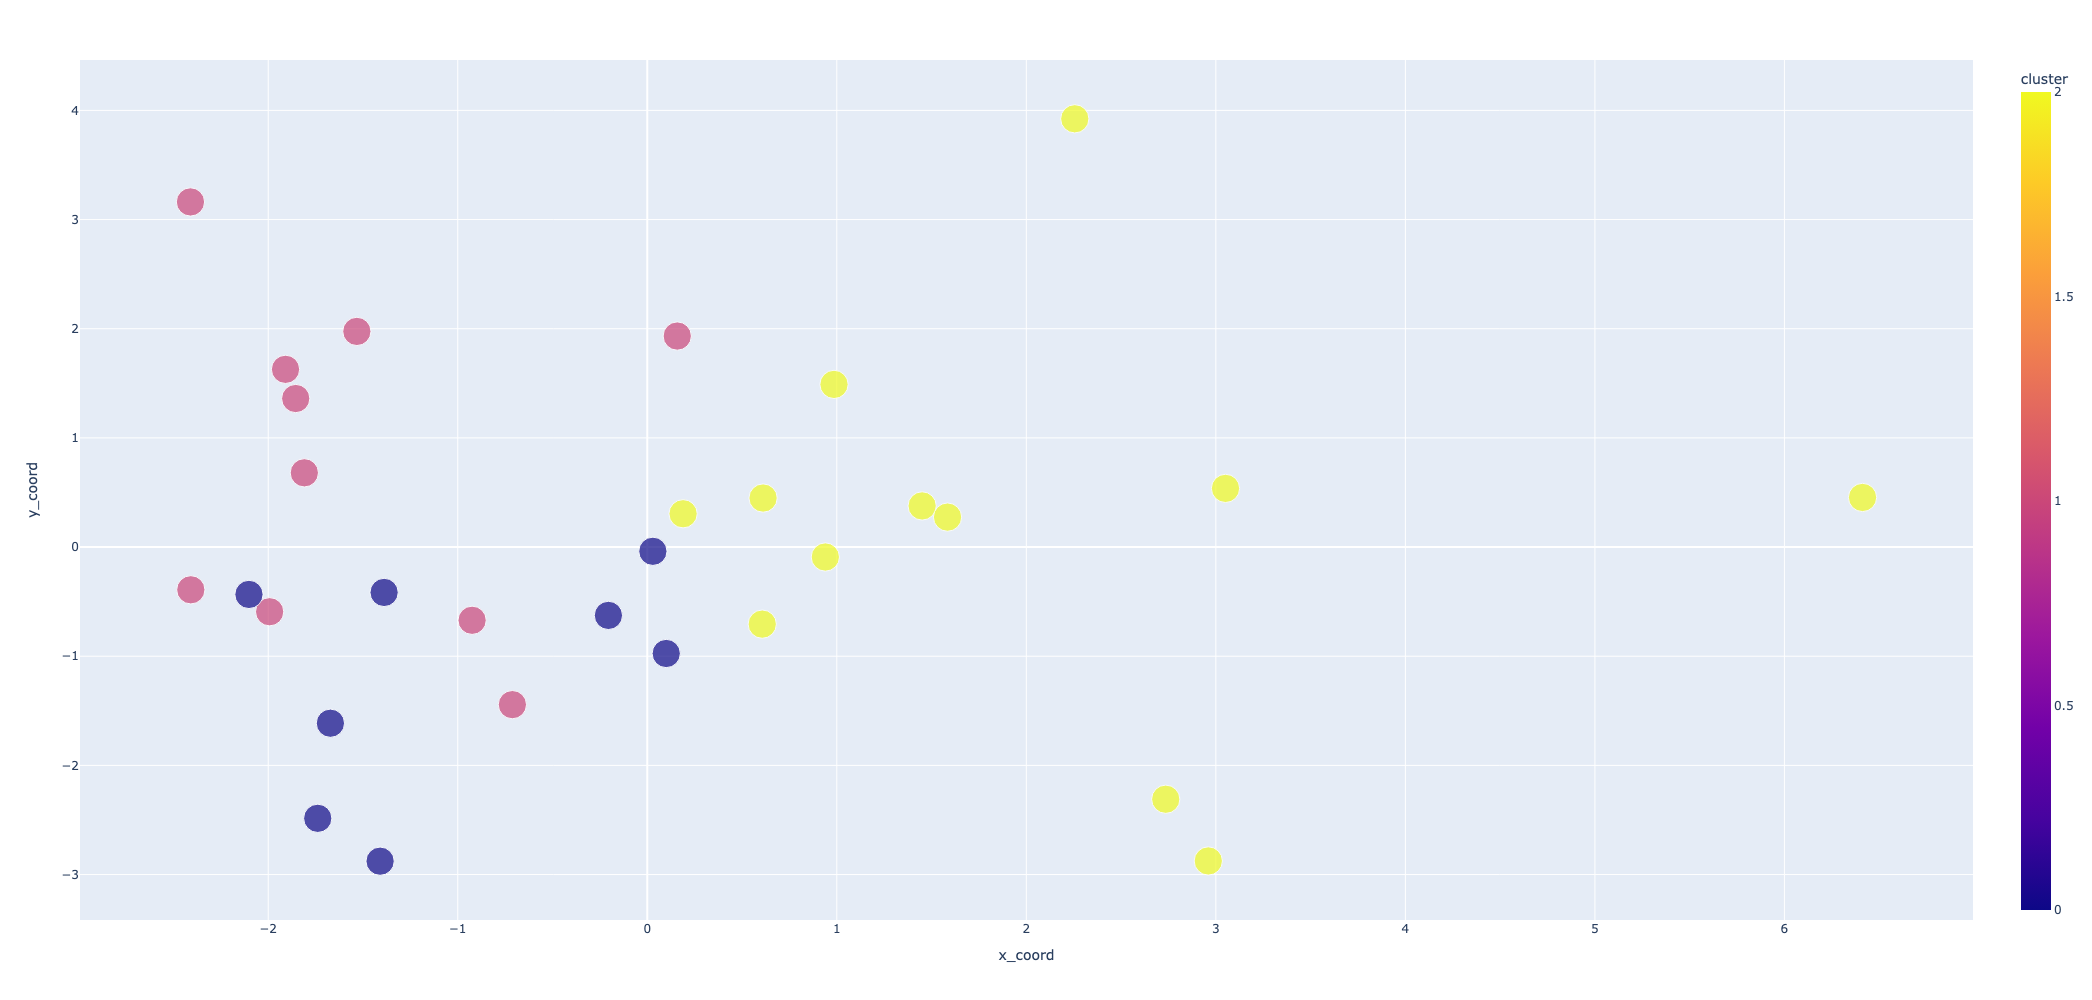

In [78]:
px.scatter(df, x='x_coord', y='y_coord', color='cluster', hover_data=['TEAM_ID', 'AST', 'REB', 'STL', 'BLK', 'PTS'], height=1000, size=np.repeat(10, len(df)))

In [71]:
# boxscore by team

data = dfs['games_details']

# only use season 2021
data = data[data['SEASON']==2021]

# select team data for home and away games
team_data = []
for s in ['home', 'away']:
    df = data[data[f'TEAM_ID_{s}']==team_id]
    df = df[[col for col in df.columns if col.endswith(f'_{s}')]]
    df.columns = df.columns.str.rstrip(f'_{s}')
    team_data.append(df)

# combine data
team_data = pd.concat(team_data)
# aggregate data by calculating mean
team_data_agg = team_data.mean().to_frame().T

return jsonify(team_data_agg.to_dict("records"))

KeyError: 'SEASON'

# Prediction

## Build dataset

In [92]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
import pandas as pd

In [165]:
train_data = []
for season in REGULAR_SEASON_DURATION:
    train_data.append(get_train_data(season))
    
train_data = pd.concat(train_data, axis=0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1], test_size=0.2, random_state=0)

In [141]:
train_data.describe()

,AST_home,BLK_home,DREB_home,FG3A_home,FG3M_home,FGA_home,FGM_home,FTA_home,FTM_home,OREB_home,...,FG3M_away,FGA_away,FGM_away,FTA_away,FTM_away,OREB_away,PF_away,STL_away,TO_away,HOME_TEAM_WINS
count,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,...,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000,4799.000000
mean,24.985639,5.021162,35.077939,33.189455,11.955297,88.842936,41.349378,22.632447,17.457254,10.250376,...,11.747077,88.909177,40.705512,22.066657,17.003305,10.073065,20.307304,7.777986,13.542960,0.565534
std,2.314387,0.812509,1.916459,4.836472,1.865766,3.347130,2.155279,2.291854,1.743965,1.083768,...,1.866499,3.671378,2.283193,2.149466,1.629843,1.185322,1.492505,0.847004,1.216547,0.495738
min,19.951220,2.268293,31.097561,23.268293,8.365854,81.926829,36.853659,16.658537,12.658537,8.146341,...,7.512195,82.146341,36.634146,16.780488,11.926829,7.527778,17.048780,6.073171,10.638889,0.000000
25%,23.390244,4.585366,34.048780,30.138889,10.707317,86.585366,39.585366,20.926829,16.073171,9.341463,...,10.439024,86.097561,38.975610,20.707317,16.170732,9.365854,19.222222,7.243902,12.853659,0.000000
50%,24.585366,5.055556,34.878049,32.756098,11.707317,88.170732,41.170732,22.250000,17.390244,10.170732,...,11.609756,88.414634,40.195122,22.073171,17.000000,9.975610,20.219512,7.658537,13.487805,1.000000
75%,26.682927,5.512195,35.944444,36.512195,13.250000,90.333333,42.805556,23.951220,18.361111,10.975610,...,12.707317,90.975610,42.277778,23.222222,17.804878,10.666667,21.243902,8.317073,14.170732,1.000000
max,30.682927,7.756098,41.500000,46.439024,17.972222,98.055556,47.694444,28.292683,22.341463,13.463415,...,16.527778,101.333333,46.944444,29.365854,23.146341,15.000000,23.902439,9.916667,17.512195,1.000000


## Train model

In [181]:
teams_2021 = dfs['games'][dfs['games']['SEASON'] == 2021]['TEAM_ID_home'].unique()

In [195]:
team_id = 1610612738
is_home = True
all_bs[(all_bs['TEAM_ID']==team_id) & (all_bs['is_home']==is_home)][PRED_COLS]

,AST,BLK,DREB,FG3A,FG3M,FGA,FGM,FTA,FTM,OREB,PF,STL,TO
1,24.512195,5.682927,34.707317,35.682927,12.560976,87.268293,40.707317,20.512195,16.780488,10.902439,18.0,7.463415,13.097561


In [202]:
model.predict(np.zeros((1, 26)))[0]

0.6498218474747495

In [192]:
# precompute all boxscores for quick retrieval

teams = []
is_homes = []
bxs = []
for team in teams_2021:
    for is_home in [False, True]:
        bs = get_team_boxscore(team, is_home)
        teams.append(team)
        is_homes.append(is_home)
        bxs.append(bs)
        

all_bs = pd.concat(bxs, axis=0)
all_bs['is_home'] = is_homes
all_bs['TEAM_ID'] = teams
all_bs = all_bs.reset_index(drop=True)

all_bs.to_csv(os.path.join(DATA_ROOT, 'preprocessed', 'boxscores.csv'))

In [142]:
# using sklearn API

# Define the LightGBM model
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=1000, max_depth=-1, learning_rate=0.1, n_estimators=10, random_state=0, objective='binary')

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('F1Score:', f1score)


Accuracy: 0.6333333333333333
F1Score: 0.7076411960132891


In [17]:
# the second column of y_pred contains the probabilities for each sample that the home team wins
y_pred_proba[:, 1]

array([0.68387777, 0.64282083, 0.37726004, 0.64918859, 0.62311851,
       0.74406518, 0.47602783, 0.38230454, 0.44447303, 0.62768571,
       0.63943213, 0.74219306, 0.60859992, 0.7537098 , 0.37984671,
       0.51776535, 0.76015321, 0.36062707, 0.41069067, 0.7964362 ,
       0.71774052, 0.73971913, 0.2477646 , 0.71860602, 0.80311956,
       0.63732972, 0.26726995, 0.67851244, 0.48667646, 0.53204247,
       0.45026022, 0.53284975, 0.44165264, 0.67177772, 0.35652342,
       0.76315916, 0.75546122, 0.60552884, 0.38378456, 0.4517262 ,
       0.61948978, 0.77642966, 0.32221397, 0.8084791 , 0.37002335,
       0.56044955, 0.66936887, 0.61015083, 0.55089459, 0.68238456,
       0.6527595 , 0.53248149, 0.55598993, 0.7882619 , 0.686962  ,
       0.58912721, 0.66838467, 0.73090379, 0.63685777, 0.77320068,
       0.5127398 , 0.50634833, 0.63484579, 0.30929026, 0.62136181,
       0.59522152, 0.49295198, 0.73664114, 0.64558424, 0.35529615,
       0.67255819, 0.62070509, 0.53336073, 0.52214611, 0.46353

In [12]:
# save trained lightgbmclassifier

import joblib

# save the trained model to disk
joblib.dump(model, 'lightgbm_model.pkl')


['lightgbm_model.pkl']

In [13]:
# load trained lightgbmclassifier

model = joblib.load('lightgbm_model.pkl')

In [208]:
# using lightgbm API

# Set LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.01,
}

# Convert the data into a LightGBM dataset object
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test)

# Train the LightGBM model
num_boost_round = 500
model = lgb.train(params=params, train_set=lgb_data, num_boost_round=num_boost_round, valid_sets=[lgb_val], early_stopping_rounds=50)

# Predict on some test data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred > 0.5)
f1score = f1_score(y_test, y_pred > 0.5)
print('Accuracy:', accuracy)
print('F1Score:', f1score)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Info] Number of positive: 2148, number of negative: 1691
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2666
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559521 -> initscore=0.239217
[LightGBM] [Info] Start training from score 0.239217
[1]	valid_0's binary_logloss: 0.677769
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.676788
[3]	valid_0's binary_logloss: 0.675789
[4]	valid_0's binary_logloss: 0.674794
[5]	valid_0's binary_logloss: 0.673879
[6]	valid_0's binary_logloss: 0.672921
[7]	valid_0's binary_logloss: 0.671976
[8]	valid_0's binary_logloss: 0.671181
[9]	valid_0's binary_logloss: 0.670338
[10]	valid_0's binary_logloss: 0.669436
[11]	valid_0's binary_logloss: 0.668608
[12]	valid_0's b

In [209]:
# save booster to disk
model_string = model.model_to_string()

with open('lightgbm.txt', 'w') as f:
    f.write(model_string)

#### SHAP with Booster (from notebook)

In [238]:
explainer = shap.TreeExplainer(model, data=X_train, model_output='probability', feature_names=X_train.columns)

In [234]:
import pickle

# save tree explainer to disk
with open(os.path.join(DATA_ROOT, 'precomputed', 'TreeExplainer.pkl'), 'wb') as f:
    pickle.dump(explainer, f)

In [236]:
# load tree explainer from disk
with open(os.path.join(DATA_ROOT, 'precomputed', 'TreeExplainer.pkl'), 'rb') as f:
    explainer = pickle.load(f)

In [240]:
shap_values = explainer.shap_values(np.zeros((1, 26)))

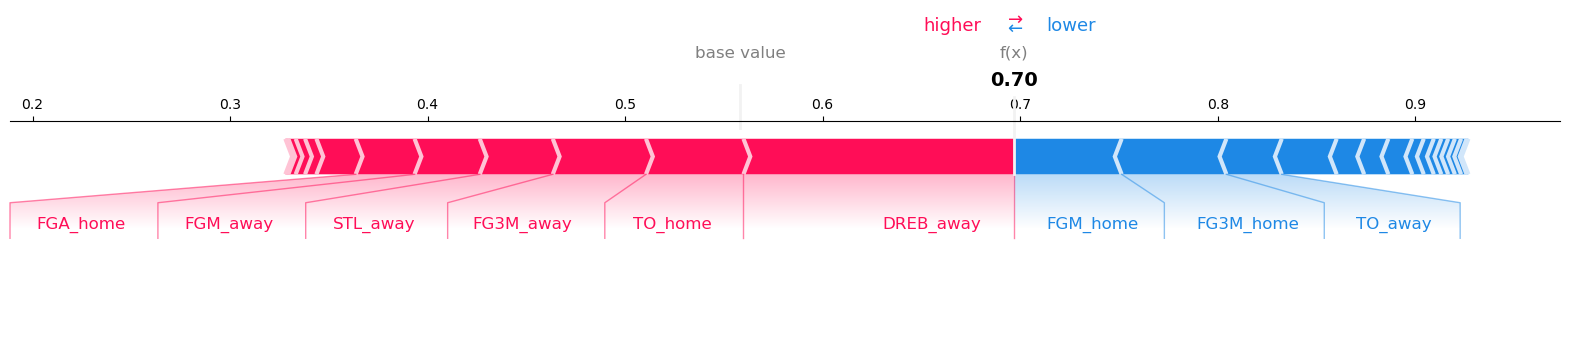

In [241]:
ind = 0
shap.force_plot(explainer.expected_value, shap_values[ind], text_rotation=0, matplotlib=True, feature_names=X_train.columns)

In [232]:
plot.html()

'\n<div id=\'i6MD59G5VZX1PUH5WMGQ5\'>\n<div style=\'color: #900; text-align: center;\'>\n  <b>Visualization omitted, Javascript library not loaded!</b><br>\n  Have you run `initjs()` in this notebook? If this notebook was from another\n  user you must also trust this notebook (File -> Trust notebook). If you are viewing\n  this notebook on github the Javascript has been stripped for security. If you are using\n  JupyterLab this error is because a JupyterLab extension has not yet been written.\n</div></div>\n <script>\n   if (window.SHAP) SHAP.ReactDom.render(\n    SHAP.React.createElement(SHAP.AdditiveForceVisualizer, {"outNames": ["f(x)"], "baseValue": 0.558123292808234, "outValue": 0.4373876429203991, "link": "identity", "featureNames": ["AST_home", "BLK_home", "DREB_home", "FG3A_home", "FG3M_home", "FGA_home", "FGM_home", "FTA_home", "FTM_home", "OREB_home", "PF_home", "STL_home", "TO_home", "AST_away", "BLK_away", "DREB_away", "FG3A_away", "FG3M_away", "FGA_away", "FGM_away", "FTA_

In [231]:
plot = shap.force_plot(explainer.expected_value, shap_values[ind], text_rotation=0, matplotlib=False, feature_names=X_train.columns)

## Train other models

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [304]:
clf = RandomForestClassifier()

param_distributions = {
    "n_estimators": optuna.distributions.IntDistribution(10, 1000, log=True),
    "max_depth": optuna.distributions.IntDistribution(1, 5),
    
}

optuna_search = optuna.integration.OptunaSearchCV(
    clf, param_distributions, n_trials=100, timeout=600, verbose=2
)

X, y = load_iris(return_X_y=True)
optuna_search.fit(X, y)

print("Best trial:")
trial = optuna_search.study_.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
dtrain = lgb.Dataset(data, label=target)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

tuner = lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds=KFold(n_splits=3),
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

In [77]:
team_id = 1610612738
is_home = 1

In [81]:
data_dict = {
            'FGM_home': 0, 
            'FGA_home': 0, 
            'FG3M_home':0, 
            'FG3A_home':0, 
            'FTM_home': 0, 
            'FTA_home': 0, 
            'OREB_home':0, 
            'DREB_home':0, 
            'AST_home': 0, 
            'STL_home': 0, 
            'BLK_home': 0, 
            'TO_home': 0,
            'PF_home': 0,
            'FGM_away': 0, 
            'FGA_away': 0, 
            'FG3M_away':0, 
            'FG3A_away':0, 
            'FTM_away': 0, 
            'FTA_away': 0, 
            'OREB_away':0, 
            'DREB_away':0, 
            'AST_away': 0, 
            'STL_away': 0, 
            'BLK_away': 0, 
            'TO_away': 0, 
            'PF_away': 0
        }

# SHAP

In [125]:
[col+"_home" for col in PRED_COLS]+[col+"_away" for col in PRED_COLS]

['AST_home',
 'BLK_home',
 'DREB_home',
 'FG3A_home',
 'FG3M_home',
 'FGA_home',
 'FGM_home',
 'FTA_home',
 'FTM_home',
 'OREB_home',
 'PF_home',
 'STL_home',
 'TO_home',
 'AST_away',
 'BLK_away',
 'DREB_away',
 'FG3A_away',
 'FG3M_away',
 'FGA_away',
 'FGM_away',
 'FTA_away',
 'FTM_away',
 'OREB_away',
 'PF_away',
 'STL_away',
 'TO_away']

In [101]:
import shap
import joblib

# save the trained model to disk
model = joblib.load('lightgbm_model.pkl')

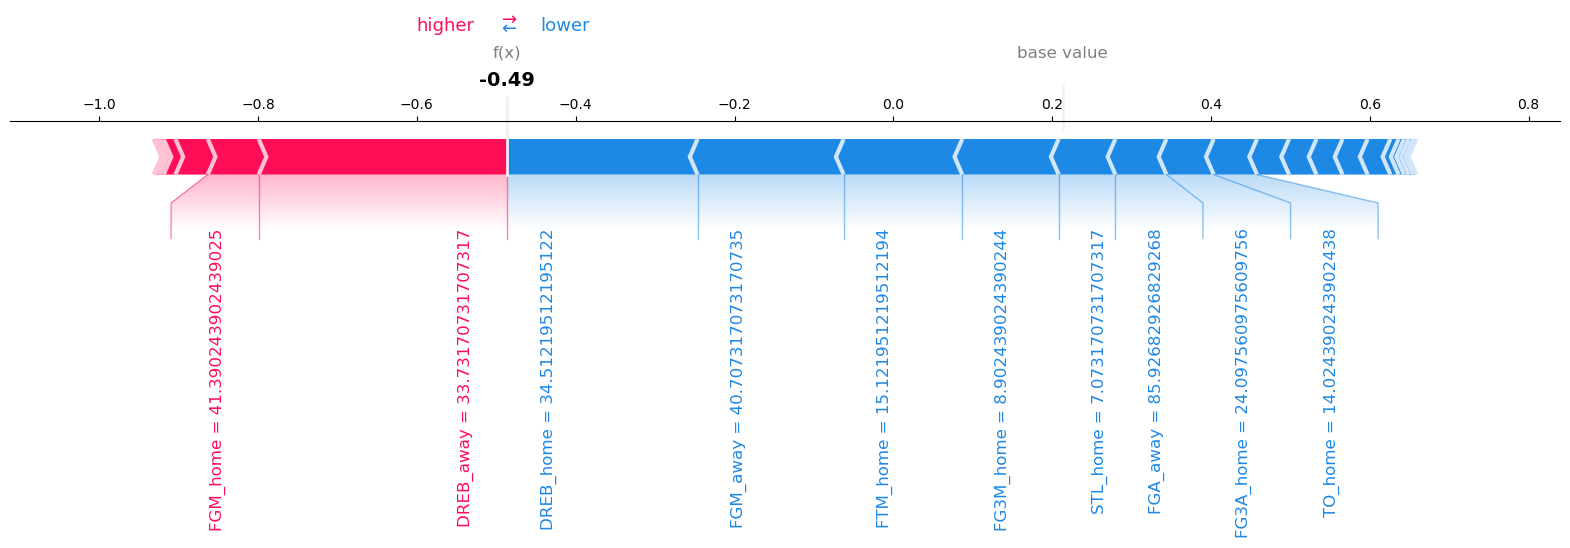

In [124]:
# X_train = pd.read_csv(os.path.join(DATA_ROOT, 'preprocessed', 'X_train.csv'), index_col=0)

explainer = shap.Explainer(model, X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)

ind = 4
force_plot = shap.plots.force(shap_values[ind], text_rotation=90, 
                     matplotlib=True)

In [109]:
ind_feat = X_test.iloc[ind].to_frame().T
ind_pred = model.predict_proba(ind_feat)
ind_pred

array([[0.61916489, 0.38083511]])

In [40]:
force_plot.html()

'\n<div id=\'iDZVFV0S396RZ0BZ3695M\'>\n<div style=\'color: #900; text-align: center;\'>\n  <b>Visualization omitted, Javascript library not loaded!</b><br>\n  Have you run `initjs()` in this notebook? If this notebook was from another\n  user you must also trust this notebook (File -> Trust notebook). If you are viewing\n  this notebook on github the Javascript has been stripped for security. If you are using\n  JupyterLab this error is because a JupyterLab extension has not yet been written.\n</div></div>\n <script>\n   if (window.SHAP) SHAP.ReactDom.render(\n    SHAP.React.createElement(SHAP.AdditiveForceVisualizer, {"outNames": ["f(x)"], "baseValue": 0.41256403078181075, "outValue": 0.7716502758792708, "link": "identity", "featureNames": ["AST_home", "BLK_home", "DREB_home", "FG3A_home", "FG3M_home", "FGA_home", "FGM_home", "FTA_home", "FTM_home", "OREB_home", "PF_home", "STL_home", "TO_home", "AST_away", "BLK_away", "DREB_away", "FG3A_away", "FG3M_away", "FGA_away", "FGM_away", "FT

In [114]:
shap_values

.values =
array([[-3.97577234e-02, -4.16032719e-03, -3.07676325e-01, ...,
         4.13096495e-03,  3.89116406e-03,  1.13521884e-01],
       [ 7.31788210e-03, -9.35744610e-03,  2.68142350e-01, ...,
         3.16480996e-03,  1.64113703e-02, -2.76754273e-02],
       [-4.83695962e-02, -3.70340580e-03,  5.88561484e-02, ...,
        -1.45453228e-04, -4.60376244e-03,  1.25947274e-02],
       ...,
       [ 6.43414635e-04, -1.02754769e-02,  5.89263251e-02, ...,
         3.71008918e-02,  2.62266212e-02, -7.92903921e-02],
       [-3.04633739e-02, -1.13075210e-03, -1.58766904e-01, ...,
        -4.51616680e-03,  2.92755294e-02, -7.94432154e-02],
       [-3.44904359e-03,  2.59218029e-03,  1.96069256e-02, ...,
         9.80711504e-03,  7.39978389e-02,  1.52554372e-02]])

.base_values =
array([0.21312593, 0.21312593, 0.21312593, 0.21312593, 0.21312593,
       0.21312593, 0.21312593, 0.21312593, 0.21312593, 0.21312593,
       0.21312593, 0.21312593, 0.21312593, 0.21312593, 0.21312593,
       0.2131259

In [121]:
explainer = shap.TreeExplainer(model, data=X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test)

In [122]:
shap_values

array([[-3.97577234e-02, -4.16032719e-03, -3.07676325e-01, ...,
         4.13096495e-03,  3.89116406e-03,  1.13521884e-01],
       [ 7.31788210e-03, -9.35744610e-03,  2.68142350e-01, ...,
         3.16480996e-03,  1.64113703e-02, -2.76754273e-02],
       [-4.83695962e-02, -3.70340580e-03,  5.88561484e-02, ...,
        -1.45453228e-04, -4.60376244e-03,  1.25947274e-02],
       ...,
       [ 6.43414635e-04, -1.02754769e-02,  5.89263251e-02, ...,
         3.71008918e-02,  2.62266212e-02, -7.92903921e-02],
       [-3.04633739e-02, -1.13075210e-03, -1.58766904e-01, ...,
        -4.51616680e-03,  2.92755294e-02, -7.94432154e-02],
       [-3.44904359e-03,  2.59218029e-03,  1.96069256e-02, ...,
         9.80711504e-03,  7.39978389e-02,  1.52554372e-02]])

In [123]:
import matplotlib.pyplot as plt
from shap import initjs

# Plot SHAP force plot for a specific instance
instance_index = 0
shap.force_plot(0, shap_values[instance_index], X_test.iloc[instance_index, :])

In [15]:
X_test.iloc[0].to_frame().T

,AST_home,BLK_home,DREB_home,FG3A_home,FG3M_home,FGA_home,FGM_home,FTA_home,FTM_home,OREB_home,...,FG3A_away,FG3M_away,FGA_away,FGM_away,FTA_away,FTM_away,OREB_away,PF_away,STL_away,TO_away
257,24.097561,4.365854,31.926829,23.268293,8.365854,87.04878,41.878049,24.365854,19.317073,11.04878,...,23.390244,8.512195,86.658537,40.439024,18.390244,14.804878,9.317073,19.121951,9.02439,12.658537


In [16]:
shap_values = shap.TreeExplainer(model).shap_values(X_test.iloc[0].to_frame().T)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


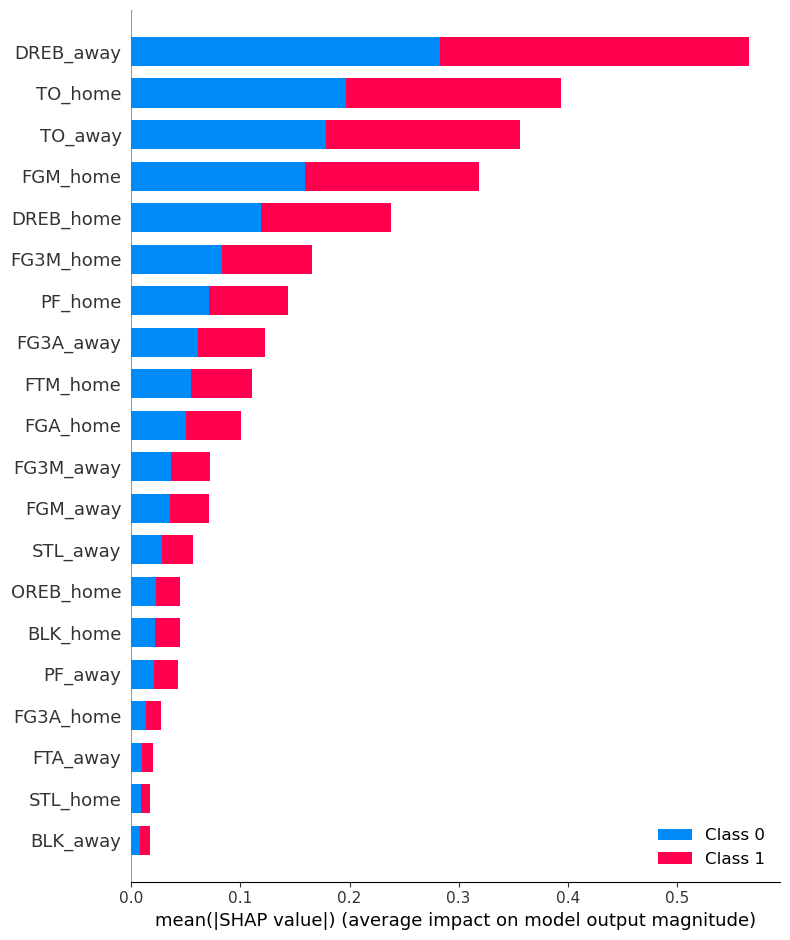

In [17]:
shap.summary_plot(shap_values, X_test.iloc[0].to_frame().T)

# Team Info

In [98]:
games = dfs['games'].copy()
teams = dfs['teams'].copy()

In [99]:
games = games[games['SEASON']==2021]

In [105]:
team_info = teams[teams['TEAM_ID'].isin(games['TEAM_ID_home'].unique())]

In [110]:
team_info['name'] = team_info.apply(lambda row: f"{row['CITY']} {row['NICKNAME']}", axis=1)

In [113]:
team_info[['TEAM_ID', 'name']].to_dict('records')

[{'TEAM_ID': 1610612737, 'name': 'Atlanta Hawks'},
 {'TEAM_ID': 1610612738, 'name': 'Boston Celtics'},
 {'TEAM_ID': 1610612740, 'name': 'New Orleans Pelicans'},
 {'TEAM_ID': 1610612741, 'name': 'Chicago Bulls'},
 {'TEAM_ID': 1610612742, 'name': 'Dallas Mavericks'},
 {'TEAM_ID': 1610612743, 'name': 'Denver Nuggets'},
 {'TEAM_ID': 1610612745, 'name': 'Houston Rockets'},
 {'TEAM_ID': 1610612746, 'name': 'Los Angeles Clippers'},
 {'TEAM_ID': 1610612747, 'name': 'Los Angeles Lakers'},
 {'TEAM_ID': 1610612748, 'name': 'Miami Heat'},
 {'TEAM_ID': 1610612749, 'name': 'Milwaukee Bucks'},
 {'TEAM_ID': 1610612750, 'name': 'Minnesota Timberwolves'},
 {'TEAM_ID': 1610612751, 'name': 'Brooklyn Nets'},
 {'TEAM_ID': 1610612752, 'name': 'New York Knicks'},
 {'TEAM_ID': 1610612753, 'name': 'Orlando Magic'},
 {'TEAM_ID': 1610612754, 'name': 'Indiana Pacers'},
 {'TEAM_ID': 1610612755, 'name': 'Philadelphia 76ers'},
 {'TEAM_ID': 1610612756, 'name': 'Phoenix Suns'},
 {'TEAM_ID': 1610612757, 'name': 'Portlan